misc imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

## Dataset

dataset config:

In [3]:
DATA_PATH = '/cobrain/groups/ml_group/data/dustpelt/salt_prep/train/'

modalities = ['image']
target = 'target'

dataset:

In [4]:
from saltsegm.dataset import Dataset

ds = Dataset(data_path = DATA_PATH, modalities=modalities, target=target)

## Cross-val split

cross validation config:

In [5]:
from saltsegm.utils import ratio2groups

n_splits = 5
val_size = 150

random_state = 42

ratio = ds.metadata['target_ratio'].values
groups = ratio2groups(ratio)

split:

In [6]:
from saltsegm.cross_validation import get_cv_111

cv_splits = get_cv_111(ds.ids, n_splits=n_splits, val_size=val_size,
                       groups=groups, random_state=random_state)

## Build experiment

experiment config:

In [7]:
EXP_PATH = '/cobrain/groups/ml_group/experiments/dustpelt/salt_segm/test_exp'

generating experiment:

In [8]:
from saltsegm.experiment import generate_experiment

# generate_experiment(exp_path=EXP_PATH, cv_splits=cv_splits, dataset=ds)

## Load experiment

In [9]:
from saltsegm.experiment import load_experiment

In [10]:
n_val = 0

x_train, y_train, x_val, y_val, x_test, y_test = load_experiment(exp_path=EXP_PATH, n_val=n_val)

## Batch iterator

batch_iter config:

In [11]:
from saltsegm.augmentation import augm_example
from saltsegm.batch_iter import BatchIter

In [12]:
batch_size=32

In [13]:
batch_iter = BatchIter(cv_splits[n_val]['train_ids'], ds.load_x, ds.load_y,
                       batch_size=batch_size, augm_fn=augm_example)

100%|██████████| 3048/3048 [00:16<00:00, 190.26it/s]


## Torch Model

In [14]:
import torch
import torch.nn as nn

from saltsegm.torch_models.example import get_Example
from saltsegm.torch_models.model import TorchModel

In [15]:
model = get_Example()

loss_fn = nn.BCEWithLogitsLoss()

learning_rate = 1e-3

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optim = torch.optim.Adam

In [16]:
model_torch = TorchModel(model=model, loss_fn=loss_fn, optim=optim, lr=learning_rate)

testing

In [17]:
l, m = model_torch.fit_generator(batch_iter.flow(), epochs=20, steps_per_epoch=len(x_train) // batch_size)

100%|██████████| 20/20 [00:44<00:00,  2.21s/it]


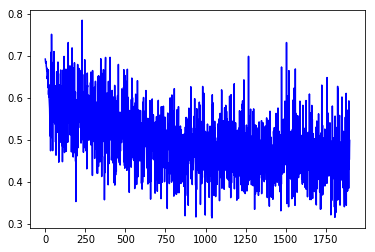

In [18]:
plt.plot(l, 'b-')
plt.show()

## Saving model, test prediction and metric values

`TODO`

## Keras model

In [17]:
import keras

from saltsegm.keras_models.simple_model import CNN

Using TensorFlow backend.


In [18]:
input_shape = (1, 101, 101)

In [19]:
model_keras = CNN(input_shape)

In [20]:
model_keras.compile(loss=keras.losses.binary_crossentropy,
                    optimizer=keras.optimizers.RMSprop(),
                    metrics=['mse'])
model_keras.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 8, 101, 101)       80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 101, 101)       72        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 101, 101)       9         
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [27]:
h = model_keras.fit_generator(batch_iter.flow(),
        epochs=2, validation_data=(x_val, y_val),
        verbose=1, steps_per_epoch=len(x_train) // 32
)

Epoch 1/2
95/95 [==============================] - 7s 73ms/step - loss: 0.6607 - mean_squared_error: 0.2340 - val_loss: 0.5991 - val_mean_squared_error: 0.2039
Epoch 2/2
95/95 [==============================] - 7s 71ms/step - loss: 0.5725 - mean_squared_error: 0.1917 - val_loss: 0.5633 - val_mean_squared_error: 0.1881


In [19]:
from saltsegm.utils import get_pred

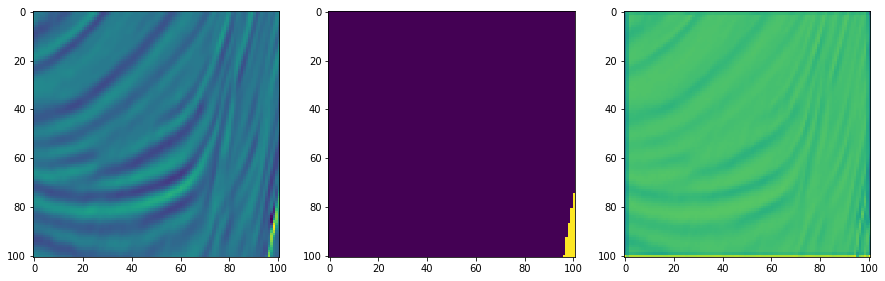

In [23]:
_id = 21

x = ds.load_x(_id)[0]
y_true = ds.load_y(_id)[0]
# y_pred = get_pred(model.predict(xs[_id:_id+1])[0])
y_pred = model.predict(xs[_id:_id+1])[0][0]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
ax_x = axs[0]
ax_true = axs[1]
ax_pred = axs[2]

ax_x.imshow(x)
ax_true.imshow(y_true)
ax_pred.imshow(y_pred)

plt.show()

In [25]:
_id=21
model.predict(xs[_id:_id+1])[0][0]

array([[0.24202004, 0.24188724, 0.24262686, ..., 0.24267848, 0.24216063,
        0.23732427],
       [0.24296154, 0.24475545, 0.24547596, ..., 0.24562743, 0.24467003,
        0.24125236],
       [0.24239239, 0.24474598, 0.24598803, ..., 0.2459156 , 0.24506399,
        0.24293512],
       ...,
       [0.24255462, 0.24475318, 0.24581227, ..., 0.24621257, 0.24574311,
        0.24348603],
       [0.24313706, 0.24447858, 0.24535015, ..., 0.24595387, 0.24525417,
        0.24291126],
       [0.24881072, 0.2469497 , 0.24804288, ..., 0.24856749, 0.24761611,
        0.24951142]], dtype=float32)

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0, # Randomly zoom image 
        width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [ ]:
model.compile()

In [ ]:
os.makedirs()